# Demo for the DoWhy causal API
We show a simple example of adding a causal extension to any dataframe. 

In [1]:
import dowhy.datasets
import dowhy.api

import numpy as np
import pandas as pd

from statsmodels.api import OLS

In [2]:
data = dowhy.datasets.linear_dataset(beta=5,
        num_common_causes=1,
        num_instruments = 0,
        num_samples=1000,
        treatment_is_binary=True)
df = data['df']
df['y'] = df['y'] + np.random.normal(size=len(df)) # Adding noise to data. Without noise, the variance in Y|X, Z is zero, and mcmc fails.
#data['dot_graph'] = 'digraph { v ->y;X0-> v;X0-> y;}'

treatment= data["treatment_name"][0]
outcome = data["outcome_name"][0]
common_cause = data["common_causes_names"][0]
df

,W0,v0,y
0,0.994081,True,5.583377
1,-0.224768,False,-0.769014
2,0.490764,True,4.496010
3,-0.313571,True,5.274824
4,0.387613,True,5.448851
...,...,...,...
995,1.111757,True,6.261306
996,1.673024,True,6.498692
997,0.740590,False,2.247448
998,-0.371145,True,4.677709


<AxesSubplot: xlabel='v0'>

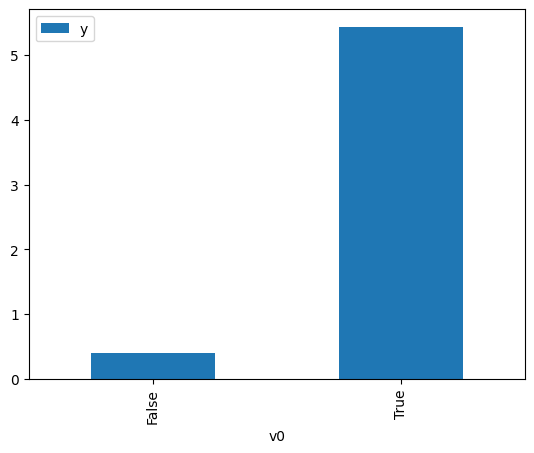

In [3]:
# data['df'] is just a regular pandas.DataFrame
df.causal.do(x=treatment,
                     variable_types={treatment: 'b', outcome: 'c', common_cause: 'c'},
                     outcome=outcome,
                     common_causes=[common_cause],
                     proceed_when_unidentifiable=True).groupby(treatment).mean().plot(y=outcome, kind='bar')

<AxesSubplot: xlabel='v0'>

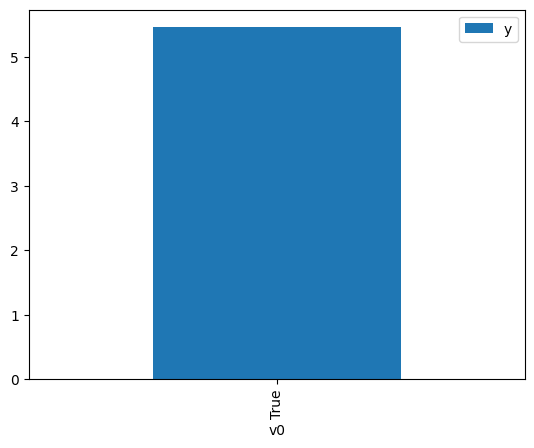

In [4]:
df.causal.do(x={treatment: 1}, 
              variable_types={treatment:'b', outcome: 'c', common_cause: 'c'}, 
              outcome=outcome,
              method='weighting', 
              common_causes=[common_cause],
              proceed_when_unidentifiable=True).groupby(treatment).mean().plot(y=outcome, kind='bar')

In [5]:
cdf_1 = df.causal.do(x={treatment: 1}, 
              variable_types={treatment: 'b', outcome: 'c', common_cause: 'c'}, 
              outcome=outcome, 
              dot_graph=data['dot_graph'],
              proceed_when_unidentifiable=True)

cdf_0 = df.causal.do(x={treatment: 0}, 
              variable_types={treatment: 'b', outcome: 'c', common_cause: 'c'}, 
              outcome=outcome, 
              dot_graph=data['dot_graph'],
              proceed_when_unidentifiable=True)


In [6]:
cdf_0

,W0,v0,y,propensity_score,weight
0,1.489551,False,-0.397503,0.218232,4.582276
1,-2.088249,False,-0.268969,0.858755,1.164476
2,0.441571,False,2.495968,0.407686,2.452869
3,-0.152797,False,0.904309,0.534519,1.870842
4,1.144298,False,1.487103,0.273152,3.660960
...,...,...,...,...,...
995,1.022637,False,0.569858,0.294439,3.396285
996,1.297967,False,1.083795,0.247681,4.037446
997,-1.160522,False,-2.103830,0.732254,1.365647
998,-0.566216,False,-2.300372,0.621120,1.609994


In [7]:
cdf_1

,W0,v0,y,propensity_score,weight
0,1.072751,True,5.460526,0.714446,1.399687
1,0.059883,True,4.082386,0.511211,1.956138
2,-0.549464,True,5.520446,0.382280,2.615882
3,-0.849595,True,5.414027,0.323368,3.092451
4,-1.214343,True,3.671180,0.258758,3.864619
...,...,...,...,...,...
995,1.511646,True,5.333007,0.784996,1.273891
996,-0.759629,True,3.880913,0.340546,2.936461
997,2.266692,True,7.102017,0.874925,1.142955
998,1.166141,True,5.494695,0.730566,1.368801


## Comparing the estimate to Linear Regression
First, estimating the effect using the causal data frame, and the 95% confidence interval.

In [8]:
(cdf_1['y'] - cdf_0['y']).mean()

In [9]:
1.96*(cdf_1['y'] - cdf_0['y']).std() / np.sqrt(len(df))

Comparing to the estimate from OLS.

In [10]:
model = OLS(np.asarray(df[outcome]), np.asarray(df[[common_cause, treatment]], dtype=np.float64))
result = model.fit()
result.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                                 OLS Regression Results                                
=======================================================================================
Dep. Variable:                      y   R-squared (uncentered):                   0.954
Model:                            OLS   Adj. R-squared (uncentered):              0.954
Method:                 Least Squares   F-statistic:                          1.042e+04
Date:                Mon, 16 Jan 2023   Prob (F-statistic):                        0.00
Time:                        04:32:17   Log-Likelihood:                         -1408.9
No. Observations:                1000   AIC:                                      2822.
Df Residuals:                     998   BIC:                                      2832.
Df Model:                           2                                                  
Covariance Type:            nonrobust                                                  
==============================================================================
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
x1             0.6989      0.034     20.734      0.000       0.633       0.765
x2             4.9985      0.051     97.684      0.000       4.898       5.099
==============================================================================
Omnibus:                        0.424   Durbin-Watson:                   2.033
Prob(Omnibus):                  0.809   Jarque-Bera (JB):                0.484
Skew:                          -0.045   Prob(JB):                        0.785
Kurtosis:                       2.941   Cond. No.                         2.39
==============================================================================

Notes:
[1] R² is computed without centering (uncentered) since the model does not contain a constant.
[2] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""